In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(42)

# 각 파일 경로를 나타내는 딕셔너리 생성
files = {
    'A': 'team2/FileA.csv',
    'B': 'team2/FileB.csv',
    'C': 'team2/FileC.csv',
    'D': 'team2/FileD.csv'
}

# 각 CSV 파일을 읽어들이고 'GROUP' 열을 추가
dfs = []
for group, file_path in files.items():
    df = pd.read_csv(file_path)  # CSV 파일 읽기
    df['GROUP'] = group  # 그룹명 추가
    dfs.append(df)  # 리스트에 데이터프레임 추가

# 모든 데이터프레임을 하나로 결합
combined_df = pd.concat(dfs, ignore_index=True)

# 결합된 데이터프레임을 출력: GROUP 열에 A, B, C, D가 구분되어 있음
combined_df

,PHCL_TM_SCOR,CLPR_CNT_SCOR,DATA_USAG_SCOR,CUST_CLCN_PREF_SCOR,LG_BRND_PREF_SCOR,FMLY_RCMD_ITNS_SCOR,DCMK_ASMP_SCOR,SAMS_MBL_ITST_SCOR,UPLS_PREF_SCOR,FMBY_HSHD_DIVS_CD,...,FSHN_MCGD_ITST_SCOR,FRPN_ITST_SCOR,HRCR_ITST_SCOR,HLCR_GODS_ITST_SCOR,HLCR_MEDC_ITST_SCOR,MKUP_ITST_SCOR,TSSU_ITST_SCOR,HPHN_ACCE_ITST_SCOR,ELAD_SCOR,GROUP
0,40224.636768,7723.101526,0.495842,0.108193,0.090386,1.669035,0.885288,8.144997,4.613053,722.384336,...,3.795828,0.092064,6.459812,0.670187,9.553784,1.193749,4.881700,9.155545,1.963303,A
1,33816.270661,15639.300388,5.975467,5.515111,0.186291,8.057594,0.984835,8.293538,3.917921,751.748406,...,2.439381,5.914378,0.943285,8.641840,2.805009,1.446986,9.095388,1.270746,9.006606,A
2,43463.606483,7858.723524,5.422305,4.653200,0.432905,3.520817,0.139040,6.316917,4.563312,962.865660,...,8.066870,4.220247,9.166391,4.646116,3.538529,0.634832,3.751465,2.152585,5.324214,A
3,36528.232940,11407.884770,3.861311,6.419427,0.508767,3.757835,0.984316,0.717949,3.575906,153.153468,...,8.438907,3.600706,5.533224,9.457854,9.282032,2.200221,2.319321,2.849202,3.155648,A
4,50445.285535,11610.217323,3.533835,6.137631,0.227219,8.362625,0.032827,7.433946,3.714784,839.459896,...,5.997270,8.276807,4.871416,4.541576,0.735512,8.581325,9.507422,4.428880,0.941173,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,58258.634249,9351.784522,4.270506,1.602205,0.779313,4.737051,0.376002,7.542745,1.910009,20.434187,...,9.737782,9.845751,5.457669,5.644992,1.556949,8.597173,8.105519,5.845530,6.040408,D
9996,26758.206219,5679.765478,3.565149,6.690892,0.289929,9.954118,0.196129,1.006162,0.121180,370.919181,...,9.115875,4.590577,5.225059,7.053855,5.180350,4.554662,9.986134,2.162288,0.878231,D
9997,36949.359768,14141.689463,7.694602,0.182507,0.114913,6.766881,0.602468,7.731969,0.503167,830.327323,...,1.183706,0.312355,6.883419,3.382862,2.812221,9.003602,4.502534,6.492427,4.244431,D
9998,16589.524297,16761.479399,5.870277,0.437882,0.826185,9.936755,0.948582,8.447413,3.116256,279.794136,...,8.885797,4.759154,0.289139,3.156588,6.392940,3.215907,5.684418,2.735748,3.264713,D


아래는 각각 데이터 전처리, 모델링 작업, 모델링 결과 출력을 위한 함수를 정의하기 위함입니다. 같은 함수를 3가지 종류에 대해 반복적으로 적용하는 구조입니다.

In [16]:
def prepare_data(df, positive_groups, negative_groups):

    # Positive에 해당하는 데이터 선별
    df_positive = df[df['GROUP'].isin(positive_groups)]
    df_positive = df_positive.drop('GROUP', axis=1)
    df_positive['y'] = 1
    # Negative에 해당하는 데이터 선별
    df_negative = df[df['GROUP'].isin(negative_groups)]
    df_negative = df_negative.drop('GROUP', axis=1)
    df_negative['y'] = 0
    print(f"{df_negative.shape[0]+df_positive.shape[0]} 건의 {str(negative_groups+positive_groups)} 고객 중 {df_positive.shape[0]} 건의 {str(positive_groups)} 고객 분류하는 데이터를 준비합니다")

    model_df = pd.concat([df_positive, df_negative])

    # 특성(X)과 타겟(y) 분리
    X = model_df.drop('y', axis=1)
    y = model_df['y']

    # 학습용 데이터와 테스트용 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return model_df, X_train, X_test, y_train, y_test

In [17]:
def modelling(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # 모델 평가
    print("혼동 행렬")
    print(confusion_matrix(y_test, y_pred))
    print("분류 모델 성능 요약")
    print(classification_report(y_test, y_pred))    
    return model, X_train, X_test, y_train, y_test

In [18]:
def explain_features(model, model_df):
    # 특성 중요도
    importances = model.feature_importances_
    features = model_df.columns[:-1]
    indices = np.argsort(importances)[::-1]

    # 중요도 시각화
    plt.title("Feature Importances")
    plt.barh(range(len(features))[::-1], importances[indices], align="center")
    plt.yticks(range(len(features))[::-1], [features[i] for i in indices])
    plt.tight_layout()
    plt.show()

위의 모든 과정을 한번에 하기 위한 wrapper 함수입니다.

In [19]:
def model_wrapper(df, positive_groups, negative_groups):
    # 데이터 준비
    model_df, X_train, X_test, y_train, y_test = prepare_data(df, positive_groups, negative_groups)
    # 모델링 수행
    model, X_train, X_test, y_train, y_test = modelling(X_train, X_test, y_train, y_test)
    # 결과 확인
    explain_features(model, model_df)

# 논플래그십 대비 플래그십 분류

10000 건의 ['B', 'C', 'D', 'A'] 고객 중 2500 건의 ['A'] 고객 분류하는 데이터를 준비합니다


혼동 행렬
[[1399   89]
 [ 481   31]]
분류 모델 성능 요약
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1488
           1       0.26      0.06      0.10       512

    accuracy                           0.71      2000
   macro avg       0.50      0.50      0.46      2000
weighted avg       0.62      0.71      0.64      2000



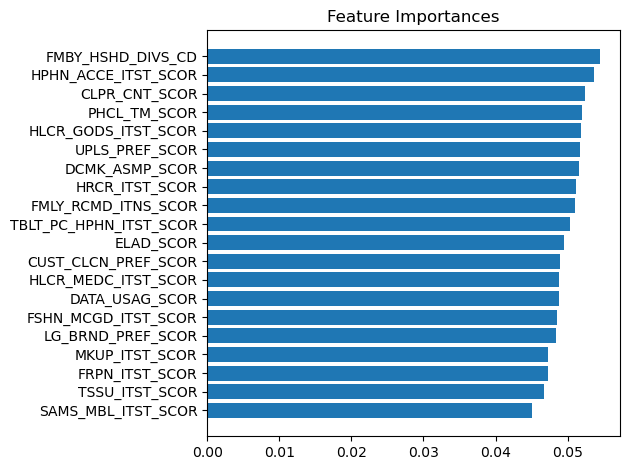

In [20]:
model_wrapper(combined_df, positive_groups=['A'], negative_groups=['B', 'C', 'D'])

# 플래그십 중 애플 대비 삼성 분류

7500 건의 ['D', 'B', 'C'] 고객 중 5000 건의 ['B', 'C'] 고객 분류하는 데이터를 준비합니다
혼동 행렬
[[ 88 393]
 [187 832]]
분류 모델 성능 요약
              precision    recall  f1-score   support

           0       0.32      0.18      0.23       481
           1       0.68      0.82      0.74      1019

    accuracy                           0.61      1500
   macro avg       0.50      0.50      0.49      1500
weighted avg       0.56      0.61      0.58      1500



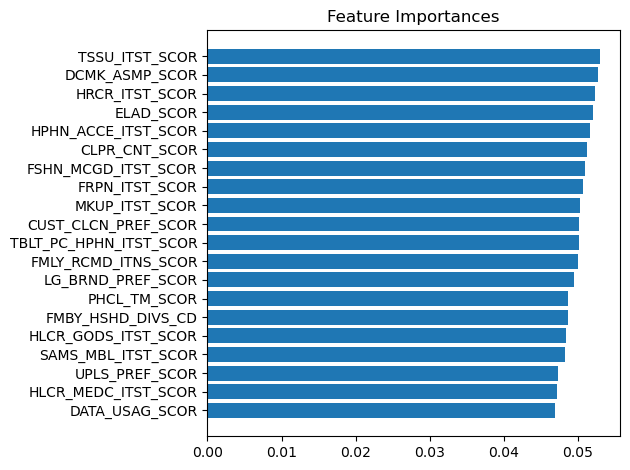

In [21]:
model_wrapper(combined_df, positive_groups=['B', 'C'], negative_groups=['D'])

# 삼성 중 플립/폴드 대비 S시리즈 분류

5000 건의 ['B', 'C'] 고객 중 2500 건의 ['C'] 고객 분류하는 데이터를 준비합니다
혼동 행렬
[[239 261]
 [244 256]]
분류 모델 성능 요약
              precision    recall  f1-score   support

           0       0.49      0.48      0.49       500
           1       0.50      0.51      0.50       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



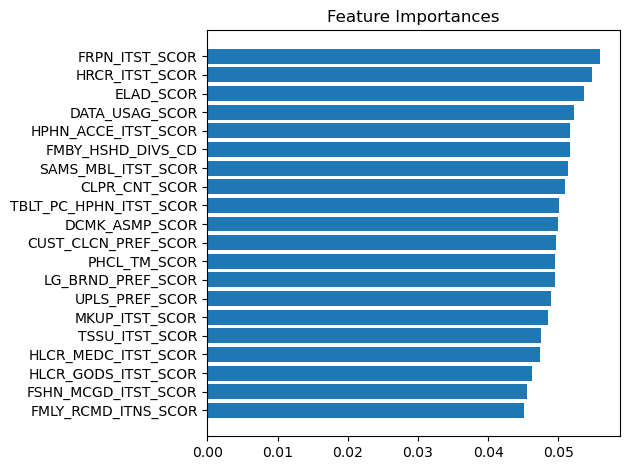

In [22]:
model_wrapper(combined_df, positive_groups=['C'], negative_groups=['B'])